In [1]:
# Import packages
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: NLTK resources (if needed for preprocessing)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load labeled dataset
df = pd.read_csv("labeled_dataset_4_categories.csv")

# Keep only the labeled rows
df = df[df["Semantic_Label_4"].isin(["support_ban", "oppose_ban", "neutral", "unrelated"])].copy()
df.reset_index(drop=True, inplace=True)

# View sample
df[["Text", "Semantic_Label_4"]].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeetshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jeetshah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jeetshah/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Text,Semantic_Label_4
0,Plastic On The Mind: Assessing the Risks From ...,support_ban
1,Scenic loch becomes magnet for Scotland's plas...,neutral
2,Trump rolls back standards for water-using app...,oppose_ban
3,Why Aren’t We Losing Our Minds Over the Plasti...,support_ban
4,36 Products That’ll Help Get You Through TSA F...,support_ban


In [2]:
# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, max_features=1000)
X_tfidf = vectorizer.fit_transform(df["Text"].astype(str))

# Shape of matrix
print("TF-IDF shape:", X_tfidf.shape)
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Save to CSV (for R)
tfidf_df
tfidf_df.to_csv("tfidf_for_hclust.csv", index=False)


TF-IDF shape: (3448, 1000)


In [3]:
tfidf_df

,000,10,100,11,12,15,20,2015,2016,2017,...,works,world,would,year,years,yet,you,young,your,zero
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.203687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.178608,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3443,0.000000,0.025400,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.112481,0.016486,0.016186,0.018467,0.027821,0.000000,0.000000,0.0,0.0
3444,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.087110,0.137892,0.015043,0.017162,0.077564,0.019777,0.000000,0.0,0.0
3445,0.000000,0.000000,0.000000,0.0,0.096611,0.000000,0.000000,0.0,0.0,0.0,...,0.054238,0.000000,0.022824,0.022409,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3446,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.074576,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [22]:
# Try multiple k values
k_values = [3, 4, 5, 6]
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_tfidf)
    score = silhouette_score(X_tfidf, labels)
    silhouette_scores.append(score)
    print(f"k = {k}, Silhouette Score = {score:.4f}")

k = 3, Silhouette Score = 0.0313
k = 4, Silhouette Score = 0.0275
k = 5, Silhouette Score = 0.0298
k = 6, Silhouette Score = 0.0293


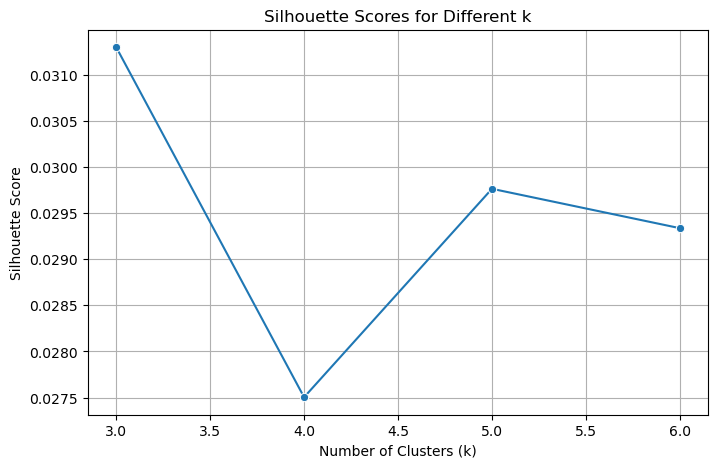

In [23]:
# Plot silhouette scores
plt.figure(figsize=(8, 5))
sns.lineplot(x=k_values, y=silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [24]:
# Reduce dimensions to 3D for clustering visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Use best_k from silhouette analysis
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
pca_labels = kmeans_final.fit_predict(X_pca)
X_pca

array([[ 0.36959468,  0.12094445, -0.09531903],
       [ 0.17058084,  0.05264514, -0.12547831],
       [-0.03916859, -0.01743695, -0.23709487],
       ...,
       [-0.06534536, -0.02611027, -0.29978957],
       [-0.08098606, -0.05785751, -0.14472057],
       [-0.09619151, -0.17654793,  0.00785392]])

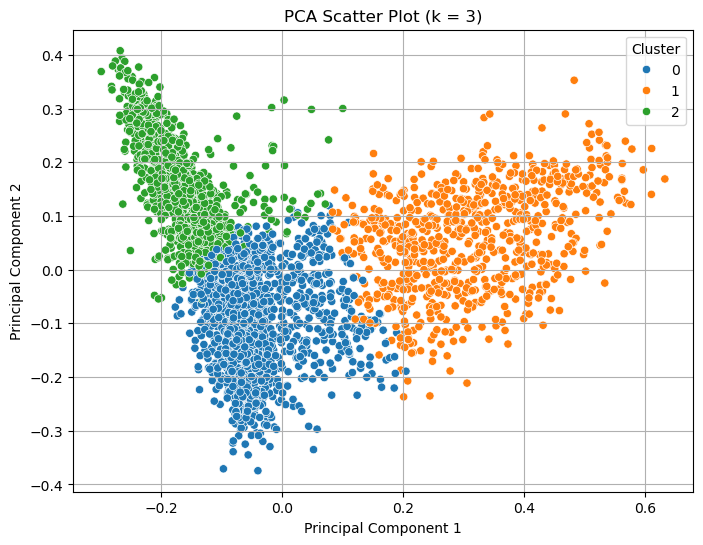

In [25]:
# Create DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
pca_df["Cluster"] = pca_labels

# 2D scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="tab10")
plt.title(f"PCA Scatter Plot (k = {best_k})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

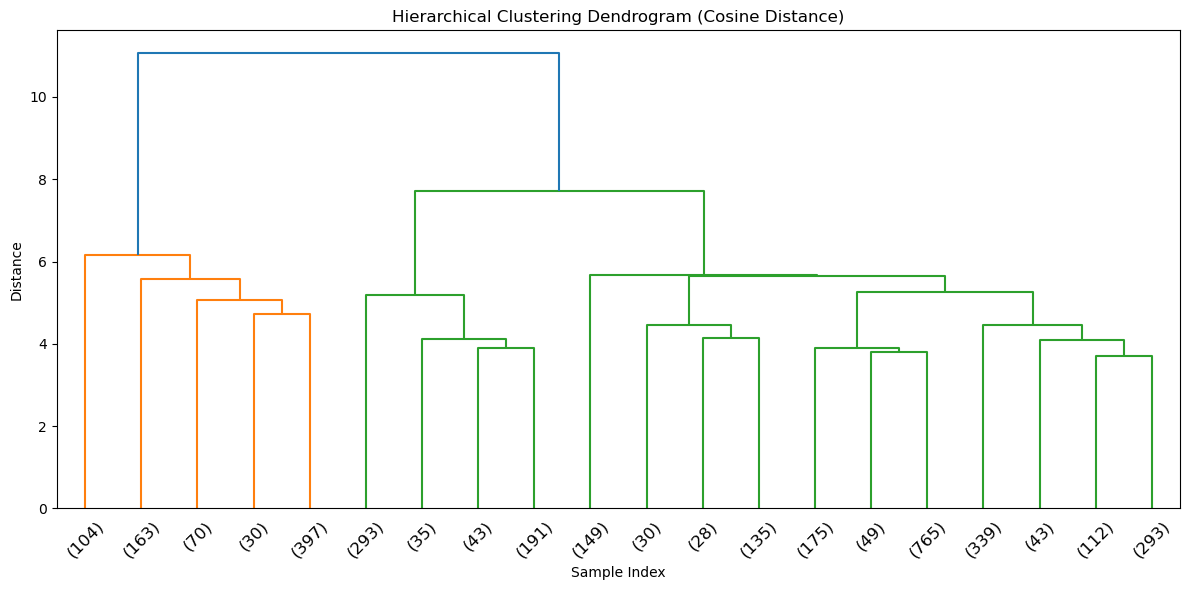

In [26]:
import numpy as np
from sklearn.preprocessing import normalize
from scipy.spatial.distance import squareform

# Convert to dense array and filter out empty rows (all zeros)
X_dense = X_tfidf.toarray()
non_empty_indices = np.where(X_dense.sum(axis=1) != 0)[0]
X_valid = X_dense[non_empty_indices]

# Normalize the valid TF-IDF vectors before cosine distance
X_valid_normalized = normalize(X_valid)

# Compute cosine distance and check for finite values
cosine_dist = pdist(X_valid_normalized, metric='cosine')
assert np.all(np.isfinite(cosine_dist)), "Non-finite values in distance matrix!"

# Linkage and dendrogram
linkage_matrix = linkage(cosine_dist, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=20, leaf_rotation=45)
plt.title("Hierarchical Clustering Dendrogram (Cosine Distance)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()